# HMMs and Viterbi algorithm for POS tagging


## Step 1: Importing Packages

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk import pos_tag

## Step 2: Understanding Dataset

In [2]:
# reading the Treebank tagged sentences
nltk.download('universal_tagset')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/ashai/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
len(nltk_data)

3914

In [4]:
# Let's view the first few tagged sentences
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

## Step 3: Data Preparation / Cleaning

- Dataset is fairly preprocessed and does not follow conventional preprocessing steps like we do for Numerical Data
- Utility Function for Word and POS tag counting
- Utility Functions to Calculate Emission & Transmission Probabilities
- Probabilty Matrix of Transmission Probabilities & Heatmap

In [5]:
# Splitting into train and validation sets in the ratio of 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,train_size=0.95, test_size=0.05, random_state=42)

print(len(train_set))
print(len(test_set))

3718
196


In [6]:
# Getting list of tagged words - train data
train_tagged_words = [tup for sent in train_set for tup in sent]
print(len(train_tagged_words))

# Getting list of tagged words - validtion data
test_tagged_words = [tup for sent in test_set for tup in sent]
print(len(test_tagged_words))

95589
5087


In [7]:
# tokens. i.e. the list of words from list of (word, tag) fom train set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Bank', 'of', 'New', 'England', "'s", 'shares', 'are', 'traded', '*-1', 'on']

In [8]:
# vocabulary
V = set(tokens)
print(len(V))

12109


In [9]:
# number of tags
T = sorted(list(set([pair[1] for pair in train_tagged_words])))
len(T)

12

In [10]:
# Let us view the tags
print(T)

['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


__The tagset consists of the following 12 coarse tags__

    . - punctuation
    ADJ - adjectives
    ADP - adpositions
    ADV - adverbs
    CONJ - conjunctions
    DET - determiners
    NOUN - nouns
    NUM - cardinal numbers
    PRON - pronouns
    PRT - particles or other function words
    VERB - verbs    
    X - other: foreign words, typos, abbreviations

### POS Tagging Algorithm using Hidden Markov Model
__Viterbi algorithm__ -> For each word, we compute the P(tag|word) for each tag in the tag set and then assign the tag having the max P(tag/word). 

P(tag|word)  = (emission probability of the word-tag pair) * (transition probability from the previous tag).<br>
i.e. P(t|w)  = P(w|t) * P(t2|t1)


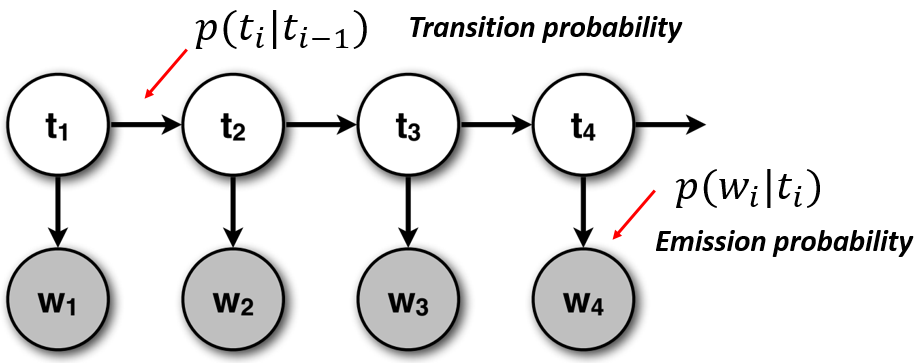


1. __Emission probability__ of a word 'w' for tag 't':
    - __P(w|t)__= (No.of times w has been tagged as t)/(No.of times t appears)
    
2. __Transition probability__ of tag t1 followed by tag t2:
    - __P(t2|t1)__= (No.of times t1 is followed by tag t2)/(No.of times t1 appears)
    
So, Let us calculate the emission and transition probabilities.



### Emission Probabilities

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute Emission Probability- P(word given tag)
def word_given_tag(word, tag, train_bag = train_tagged_words):
    
    # Calculate No.of times tag t appears
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    
    # Calculate No.of times word w has been tagged as tag t
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
#Example

print("\n", "October")
print(word_given_tag('October','NOUN'))
print(word_given_tag('October','VERB'))
print(word_given_tag('October','ADJ'))

print("\n", "reported")
print(word_given_tag('reported','NOUN'))
print(word_given_tag('reported','VERB'))
print(word_given_tag('reported','ADJ'))


 October
(53, 27423)
(0, 12885)
(0, 6077)

 reported
(0, 27423)
(34, 12885)
(0, 6077)


### Transition Probabilities

In [14]:
# Compute Transition Probability - tag2(t2) given tag1 (t1)

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    
    # Calculate No.of times tag t1 appears
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    
    # Calculate No.of times t1 is followed by tag t2
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# examples
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('VERB', 'NOUN'))

(4234, 6077)
(5302, 8284)
(1429, 12885)
(4058, 27423)


In [16]:
# Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('VERB', '.'))

(1929, 11118)
(2481, 11118)
(984, 11118)


In [17]:
# creating t x t transition matrix of tags. Each column is t2, each row is t1, thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [19]:
# Each column is t2, each row is t1
tags_df

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.093812,0.044972,0.091114,0.052078,0.057924,0.173502,0.223152,0.080500,0.065389,0.002339,0.088505,0.026623
ADJ,0.065328,0.066645,0.078986,0.004608,0.016949,0.005101,0.696725,0.020405,0.000658,0.010861,0.012342,0.021392
ADP,0.039486,0.105297,0.017228,0.013162,0.000856,0.326378,0.321776,0.062921,0.069128,0.001498,0.008240,0.034029
ADV,0.136877,0.130233,0.119601,0.081063,0.006312,0.067110,0.030897,0.030565,0.015615,0.013621,0.344518,0.023588
CONJ,0.034256,0.116847,0.054435,0.055842,0.000469,0.121539,0.349132,0.042234,0.058658,0.004693,0.153918,0.007977
DET,0.017986,0.204973,0.009054,0.012313,0.000483,0.005311,0.640029,0.021970,0.003742,0.000241,0.038387,0.045509
NOUN,0.239179,0.012289,0.176275,0.016884,0.041936,0.013310,0.264632,0.009627,0.004923,0.043832,0.147978,0.029136
NUM,0.118347,0.034196,0.034790,0.002974,0.013381,0.003271,0.355338,0.184062,0.001487,0.027951,0.017544,0.206661
PRON,0.041253,0.074866,0.022918,0.033995,0.004966,0.009549,0.211230,0.007257,0.008021,0.012223,0.480901,0.092819
PRT,0.041517,0.086303,0.021576,0.010134,0.002288,0.100360,0.242563,0.058516,0.018960,0.001635,0.402746,0.013403


In [20]:
tags_df.loc['.', :]

.       0.093812
ADJ     0.044972
ADP     0.091114
ADV     0.052078
CONJ    0.057924
DET     0.173502
NOUN    0.223152
NUM     0.080500
PRON    0.065389
PRT     0.002339
VERB    0.088505
X       0.026623
Name: ., dtype: float32

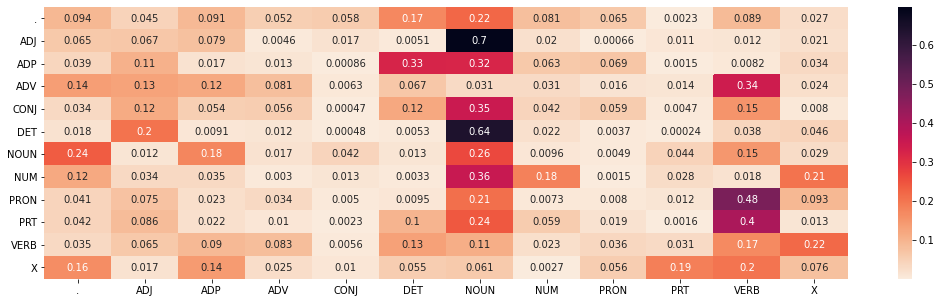

In [21]:
# heatmap of tags matrix
plt.figure(figsize=(18, 5))
sns.heatmap(tags_df, annot=True,cmap="rocket_r")
plt.show()

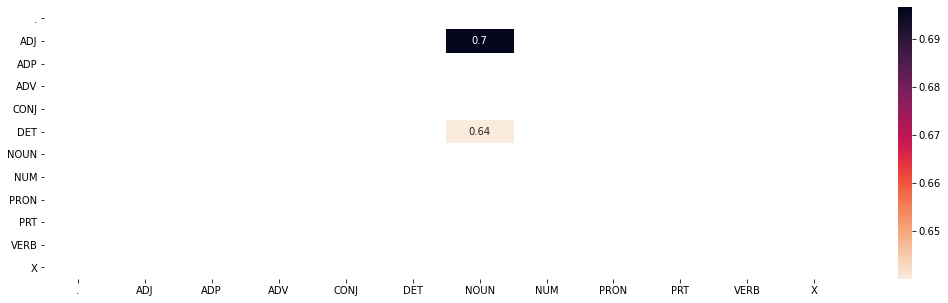

In [22]:
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18,5))
sns.heatmap(tags_frequent,annot = True,cmap="rocket_r")
plt.show()

#### From above heatmap, we can observe that most of the transition probabilities are between Noun and other parts of speech such as Adjective and Determinant.

## Step 4: Model Building


1. Vanilla Viterbi Algorithm.
2. Viterbi Modification-Approach I:
    - Transition probability is considered in case of unknown words since emission probability is zero.
3. Viterbi Modification-Approach II:
    - Trigram tagger backed off to a rule based tagger in case of an unknown word.
4. Checked the tagging accuracies on the sample test sentences.
5. Listed down cases which were incorrectly tagged by original POS tagger and got corrected by modified approaches. 

### Build the Vanilla Viterbi based POS tagger

- The Viterbi algorithm takes a greedy heuristic. 
- It starts from the start of a sentence and at every step maximizes the likelihood of this tag sequence that is likely to be assigned to this sentence so far.

In [23]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    
    # Take the list of unique tags present in the corpus
    T = sorted(list(set([pair[1] for pair in train_bag])))
        
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        
        for tag in T:
            if key == 0: #first word has key=0
                transition_p = tags_df.loc['.', tag]                 
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating on Validation/Test Set

In [24]:
# Let's test our Viterbi algorithm on the validation dataset which is 5% of the entire dataset

random.seed(1234)
# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# take the list of words alone without the tags
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [25]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [26]:
# Below code takes around 11 mins to execute
print("Time taken in seconds: ", difference)

Time taken in seconds:  805.6377885341644


In [27]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [28]:
accuracy = len(check)/len(tagged_seq)

In [29]:
accuracy

0.9138981718104974

In [30]:
incorrect_tagged_cases = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [31]:
incorrect_tagged_cases[:5]

[(('trade', 'VERB'), ('trade', 'NOUN')),
 (('Overseas', '.'), ('Overseas', 'NOUN')),
 (('Private', 'ADJ'), ('Private', 'NOUN')),
 (('pre-1917', '.'), ('pre-1917', 'ADJ')),
 (('Unemployment', '.'), ('Unemployment', 'NOUN'))]

The incorrect tagged cases can be attributed to the fact that when the algorithm hits an unknown word (i.e. not present in the training set hence emission probability is 0), it naively assigns the first tag in the list of tags that we have created.

### Solve the problem of unknown words
### Viterbi Modification-Technique I
#### Use transition probability of tags when emission probability is zero (in case of unknown words)

If a word is not present in the training vocabulary i.e. unknown word, then its emission probability will be 0 and hence The state probability will also be zero. Therefore in cases where the algorithm encounters a word which it has not see previously, we can leave out the emission probability and consider only the transition probability.

The vanilla viterbi algorithm can be modified as given below as part of Approach I:

__If word is unknown then,<br>
consider only the transition prob (since, emission probability will be 0)<br>
Else<br>
consider both the emission and transition probabilities as state probability.__

In [32]:
# Modified Viterbi Heuristic- Approach I
def Viterbi_approach1(words, train_bag = train_tagged_words):
    state = []
    
    # Take the list of unique tags present in the corpus
    T = sorted(list(set([pair[1] for pair in train_bag])))
    V = [i[0] for i in train_bag]
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        
        for tag in T:
            if key == 0: #first word has key=0
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm. 
            # Vocab contains the list of unique words in training dataset
            if word not in V: 
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [33]:
# tagging the test sentences
start = time.time()
transition_tagged_seq = Viterbi_approach1(test_tagged_words)
end = time.time()
difference = end-start

In [34]:
# Below code takes around 11 mins to execute
print("Time taken in seconds: ", difference)

Time taken in seconds:  745.3578000068665


In [35]:
# accuracy
transition_check = [i for i, j in zip(transition_tagged_seq, test_run_base) if i == j] 

In [36]:
transition_accuracy = len(transition_check)/len(transition_tagged_seq)

In [37]:
transition_accuracy

0.9388637703951248

In [38]:
transition_incorrect_tagged_cases = [j for i, j in enumerate(zip(transition_tagged_seq, test_run_base)) if j[0]!=j[1]]

In [39]:
transition_incorrect_tagged_cases[:5]

[(('trade', 'VERB'), ('trade', 'NOUN')),
 (('Private', 'ADJ'), ('Private', 'NOUN')),
 (('pre-1917', 'X'), ('pre-1917', 'ADJ')),
 (('purchasing', 'NOUN'), ('purchasing', 'VERB')),
 (('reasonably', 'NOUN'), ('reasonably', 'ADV'))]

We see the modified viterbi algorithm performs better than the original vanilla viterbi algorithm. The modified viterbi achieves an accuracy of approx. 93.88% compared to 91.38% of the vanilla viterbi algorithm.

Still there is a loss of approx. 6.12%.

Compared to the vanilla viterbi on the validation dataset, there is a slight improvement in modified viterbi-approach I.
We can see that the word 'copied' which was incorrect in vanilla viterbi has been correctly identified as 'VERB' by modified viterbi Approach I.

| Incorrect Tag-Original POS Tagger | Corrected Tag-Modified Approach I |
| :--- | --- |
| ('Overseas', '.') | ('Overseas', 'NOUN') |
| ('Unemployment', '.') | ('Unemployment', 'NOUN') |
| ('paycheck', '.') | ('paycheck', 'NOUN') |
| ('Funded', '.') | ('Funded', 'VERB') |
| ('existed', '.') | ('existed', 'VERB') |
 
Now lets see if we can improve further using 2nd Approach.

### Lexicon and Rule-Based Models for POS Tagging

#### Unigram Tagger

In [40]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(test_set)

0.911735797129939

####  Let us combine the unigram tagger with a rule based regex tagger.

In [41]:
# patterns for tagging using a rule based tagger
patterns = [
    (r'.*\'s$', 'NOUN'),                     # possessive nouns
    (r'.*s$', 'NOUN'),                       # plural nouns
    (r'^[aA-zZ].*[0-9]+','NOUN'),            
    (r'.*ness$', 'NOUN'),                    # words ending with 'ness' such as 'sluggishness' 
    (r'.*', 'NOUN'), 
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),     
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),       # words ending with 'ed' or 'ing' or 'es'    
    (r'.*ly$', 'ADV'),                       # words ending with 'ly'    
    (r'^[0-9]+(.[0-9]+)?$', 'NUM'),          # cardinal numbers such as 61, 1956, 9.8, 8.45, 352.7        
    (r'(The|the|A|a|An|an)$', 'DET')
    ]

In [42]:
# Rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)
rule_based_unigram_tagger.evaluate(test_set)

0.9378808728130529

In [43]:
# Bigram tagger backed up by the rule-based-unigram tagger
bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)

0.9412227245920975

In [44]:
# trigram tagger
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)

0.9404364065264399

### Viterbi Modification-Technique II

__Approach 2__ : Rule Based engine on unknown words, by modifying the Viterbi Algorithm. If the state of the word is zero then use rule based engine to tag vocabulary to the words.

We saw that the Trigram Tagger backed up by the bigram tagger gives an accuracy of about 96%. Let's now try to modify the viterbi algorithm to use this trigram tagger as a back-off. When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [45]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    # specify patterns for tagging. I have identified most of the patterns from the first 100 sentences in universal dataset
    patterns = [
    (r'^([0-9]|[aA-zZ])+\-([0-9]|[aA-zZ])*$','ADJ'), # words such as '10-lap','30-day','York-based'
    (r'.*able$', 'ADJ'),                     # words ending with 'able' such as 'questionable'
    (r'.*ful$', 'ADJ'),                      # words ending with 'ful' such as 'useful'
    (r'.*ous$', 'ADJ'),                      # words ending with 'ous' such as 'Previous'
    
    (r'.*\'s$', 'NOUN'),                     # possessive nouns
    (r'.*s$', 'NOUN'),                       # plural nouns
    (r'^[aA-zZ].*[0-9]+','NOUN'),            # Alpha Numeric such as Door Number, Street Number etc
    (r'.*ers$', 'NOUN'),                     # words ending with 'ers' such as 'filters','workers'
    (r'.*ment$', 'NOUN'),                    # words ending with 'ment' such as 'reinvestment' 
    (r'.*town$', 'NOUN'),                    # words ending with 'town' such as 'town','downtown'  
    (r'.*ness$', 'NOUN'),                    # words ending with 'ness' such as 'sluggishness' 
    (r'^[A-Z]+([a-z]{1,2})?\.?$','NOUN'),    # words such as 'Nov.','Mr.','Inc.'
    
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),       # words ending with 'ed' or 'ing' or 'es'    
    (r'.*ly$', 'ADV'),                       # words ending with 'ly'
    
    (r'^[0-9]+(.[0-9]+)?$', 'NUM'),          # cardinal numbers such as 61, 1956, 9.8, 8.45, 352.7        
    (r'^(0|([*|-|$].*))','X'),               # words such as '*', '0', *-1', '*T*-1', '*ICH*-1', '*?*'   
    
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # determinants     
    (r'.*', 'NOUN')  
    ]
    
    rule_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = rule_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])    

In [46]:
# Modified Viterbi Heuristic- Approach II - Backoff to rule based tagger in case an unknown word is encountered.
def Viterbi_approach2(words, train_bag = train_tagged_words):
    state = []
    T = sorted(list(set([pair[1] for pair in train_bag])))
    V = [i[0] for i in train_bag]
    
    # use the trigram tagger backed up by the rule based tagger for unknown words.
    for key, word in enumerate(words):
        if word not in V:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [47]:
# tagging the test sentences. Below code takes around 49 mins to execute
start = time.time()
viterbi_trigram_tagged_seq = Viterbi_approach2(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)
viterbi_trigram_accuracy

Time taken in seconds:  1128.8688714504242


0.9618635738156084

In [48]:
viterbi_trigram_incorrect_tagged_cases = [j for i, j in enumerate(zip(viterbi_trigram_tagged_seq, test_run_base)) if j[0]!=j[1]]
viterbi_trigram_incorrect_tagged_cases[:5]

[(('trade', 'VERB'), ('trade', 'NOUN')),
 (('Private', 'ADJ'), ('Private', 'NOUN')),
 (('purchasing', 'NOUN'), ('purchasing', 'VERB')),
 (('though', 'ADP'), ('though', 'ADV')),
 (('close', 'NOUN'), ('close', 'ADJ'))]

 __Observations__:
 
 Below words have been correctly tagged by Approach II compared to Vanilla viterbi and Modified Approach-I.

| Incorrect Tags-Original POS Tagger | Corrected Tags-Modified Approach I | Corrected Tags-Modified Approach II |
| :--- | --- | --- |
| ('pre-1917', '.') | ('pre-1917', 'X') | ('pre-1917', 'ADJ') |
| ('Tokio', '.') | ('Tokio', 'DET') | ('Tokio', 'NOUN') |
| ('20.5', '.') | ('20.5', 'NOUN') | ('20.5', 'NUM') |
| ('polarized', '.') | ('polarized', 'X') | ('polarized', 'VERB') |
| ('154.2', '.') | ('154.2', 'X') | ('154.2', 'NUM') |

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### Let us summarize the tagging accuracies we got on the Validation set
| Approach | Accuracy |
| :--- | --- |
| Vanilla Viterbi algorithm | 91.38% |
| Modified Vanilla Viterbi- Approach I(Use transition probability of tags when emission probability is zero) | 93.88% |
| Unigram/Lexicon Tagger | 91.17% |
| Unigram backed by Rule based Tagger | 93.78% |
| Bigram backed by Unigram_Rule_based tagger | 94.12% |
| Trigram backed by Bigram tagger | 94.04% |
| Viterbi+ Trigram and Rule Based tagger -Approach II | 96.18% |


### List down cases which were incorrectly tagged by original POS tagger and got corrected by our modifications
### Case 1

In [49]:
sentence_test1 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sentence_test1)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Android', '.'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', '.'), ('worldwide', '.'), ('on', 'ADP'), ('smartphones', '.'), ('since', 'ADP'), ('2011', '.'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', '.'), ('.', '.')]


In [50]:
tagged_seq_modified1 = Viterbi_approach1(words)
print(tagged_seq_modified1)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]


In [51]:
tagged_seq_modified2 = Viterbi_approach2(words)
print(tagged_seq_modified2)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


__Observations__:

| Incorrect Tags-Original POS Tagger | Corrected Tags-Modified Approach I | Corrected Tags-Modified Approach II |
| :--- | --- | --- |
| ('Android', '.') | ('Android', 'NOUN') | ('Android', 'NOUN') |
| ('OS', '.') | ('OS', 'NOUN') | ('OS', 'NOUN') |
| ('worldwide', '.') | ('worldwide', 'NOUN') | ('worldwide', 'NOUN') |
| ('smartphones', '.') | ('smartphones', 'DET') | ('smartphones', 'NOUN') |
| ('2011', '.') | ('2011', 'DET') | ('2011', 'NUM') 
| ('2013', '.') | ('2013', 'DET') | ('2013', 'NUM') 

### Case 2

In [52]:
sentence_test2 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
words = word_tokenize(sentence_test2)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Google', '.'), ('and', 'CONJ'), ('Twitter', '.'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', '.'), ('that', 'DET'), ('gave', 'VERB'), ('Google', '.'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', '.'), ("'s", 'VERB'), ('firehose', '.'), ('.', '.')]


In [53]:
tagged_seq_modified1 = Viterbi_approach1(words)
print(tagged_seq_modified1)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')]


In [54]:
tagged_seq_modified2 = Viterbi_approach2(words)
print(tagged_seq_modified2)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


__Observations__:

| Incorrect Tags-Original POS Tagger | Corrected Tags-Modified Approach I | Corrected Tags-Modified Approach II |
| :--- | --- | --- |
| ('Google', '.') | ('Google', 'NOUN') | ('Google', 'NOUN') |
| ('Twitter', '.') | ('Twitter', 'NOUN') | ('Twitter', 'NOUN') |
| ('2015', '.') | ('2015', 'DET') | ('2015', 'NUM') |
| ('Google', '.') | ('Google', 'X') | ('Google', 'NOUN') |
| ('Twitter', '.') | ('Twitter', 'VERB') | ('Twitter', 'NOUN') |
| ('firehose', '.') | ('firehose', 'VERB') | ('firehose', 'NOUN') |

### Case 3

In [55]:
sentence_test3 = "The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years."
words = word_tokenize(sentence_test3)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('The', 'DET'), ('2018', '.'), ('FIFA', '.'), ('World', 'NOUN'), ('Cup', '.'), ('is', 'VERB'), ('the', 'DET'), ('21st', '.'), ('FIFA', '.'), ('World', 'NOUN'), ('Cup', '.'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', '.'), ('contested', '.'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [56]:
tagged_seq_modified1 = Viterbi_approach1(words)
print(tagged_seq_modified1)

[('The', 'DET'), ('2018', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'NOUN'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [57]:
tagged_seq_modified2 = Viterbi_approach2(words)
print(tagged_seq_modified2)

[('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


__Observations__:

| Incorrect Tags-Original POS Tagger | Corrected Tags-Modified Approach I | Corrected Tags-Modified Approach II |
| :--- | --- | --- |
| ('2018', '.') | ('2018', 'NOUN') | ('2018', 'NUM') |
| ('FIFA', '.') | ('FIFA', 'NOUN') | ('FIFA', 'NOUN') |
| ('Cup', '.') | ('Cup', 'NOUN') | ('Cup', 'NOUN') |
| ('contested', '.') | ('contested', 'NOUN') | ('contested', 'VERB') |


We can see that in all the above 3 cases, unknown words are being tagged as '.'(punctuation) because it is the first tag in the list of all tags.<br> 

Also, the first modified approach was able to correctly tag only few of the incorrect words while the second modified approach was able to perform much better than the 1st approach.